In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
#setting for # of iterations, train/test set size, sd of noise
n_repeat = 50
n_train = 50
n_test = 1000
noise = 0.1
np.random.seed(0)

# # Change the following parameters for exploring the bias-variance decomposition of other
# # estimators. This should work well for estimators with high variance (e.g.,
# # decision trees or KNN), but poorly for estimators with low variance (e.g.,
# # linear models).
# param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':4}
# estimators = [("Tree", DecisionTreeRegressor(**param)),
#               ("Bagging(Tree)", BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(**param))),
#              ("RandomForest(Tree)",RandomForestRegressor(n_estimators=100, **param)),
#              ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, **param))]

In [13]:
def compare_estimators(estimators):
    n_estimators = len(estimators)
    #Generate data
    def f(x):
        x = x.ravel()
        return np.exp(-x**2) + 1.5*np.exp(-(x-2)**2)
    
    def generate(n_samples, noise, n_repeat = 1):
        X=np.random.rand(n_samples)*10-5
        X= np.sort(X)
        if n_repeat ==1:
            y = f(X) +np.random.normal(0.0, noise, n_samples)
        else:
            y= np.zeros((n_samples, n_repeat))
            for i in range(n_repeat):
                y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)
        X = X.reshape((n_samples,1))
        return X, y
    X_train = []
    y_train = []
    
    for i in range(n_repeat):
        X, y = generate(n_samples = n_train, noise = noise)
        X_train.append(X)
        y_train.append(y)
        
    X_test, y_test = generate(n_samples = n_test, noise = noise, n_repeat = n_repeat)
    
    #Loop over estimators to compare
    for n, (name, estimator) in enumerate(estimators):
        y_predict = np.zeros((n_test, n_repeat))
        for i in range(n_repeat):
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)
            
        #MSE = bias^2 + variance + noise
        y_error = np.zeros(n_test)
        
        for i in range(n_repeat):
            for j in range(n_repeat):
                y_error +=(y_test[:,j] - y_predict[:,i] **2)
        y_error /=(n_repeat**2)
        y_noise = np.var(y_test, axis = 1)
        y_bias = (f(X_test) - np.mean(y_predict, axis = 1))**2
        y_var = np.var(y_predict, axis = 1)
        
        print("{0}: {1:.4f} (error) = {2:.4f} (bias^2)"
             " + {3:.4f} (var) + {4:.4f} noise)".format(name, 
                                                        np.mean(y_error), np.mean(y_bias),
                                                        np.mean(y_var), np.mean(y_noise))) 
        
        
        #plot figures
        plt.subplot(2, n_estimators, n+1)
        plt.plot(X_test, f(X_test), "b", label = "$f(x)$")
        plt.plot(X_train[0], y_train[0], ".b", label = "LS ~$y = f(x) + noise$")
  
        for i in range(n_repeat):
            if i == 0:
                plt.plot(X_test, y_predict[:, i], "r",label = "$\^y(x)$")
            else:
                plt.plot(X_test, y_predict[:,i], "r", alpha = 0.05)
        
        plt.plot(X_test, np.mean(y_predict, axis = 1), "c", label = "$\mathbb{E}_{LS} \^y(x)$")
        plt.xlim([-5,5])
        plt.title(name)

        if n==0:
            plt.legend(loc = "upper left", prop = {"size":11})
    
        plt.subplot(2, n_estimators, n_estimators + n + 1)
        plt.plot(X_test, y_error, "r", label = "$error(x)$")
        plt.plot(X_test, y_bias, "b", label = "$bias^2(x)$")
        plt.plot(X_test, y_var, "g", label = "$variance(x)$")
        plt.plot(X_test, y_noise, "c", label = "$noise(x)$")

        plt.xlim([-5,5])
        plt.ylim([0,0.1])

        if n == 0:
            plt.legend(loc = "upper left", prop = {"size":11})
    plt.show()

Tree: -0.0106 (error) = 0.0041 (bias^2) + 0.0134 (var) + 0.0099 noise)
Bagging(Tree): -0.0018 (error) = 0.0031 (bias^2) + 0.0063 (var) + 0.0099 noise)
RandomForest(Tree): -0.0029 (error) = 0.0032 (bias^2) + 0.0063 (var) + 0.0099 noise)
Boosting(Tree): -0.0178 (error) = 0.0004 (bias^2) + 0.0131 (var) + 0.0099 noise)


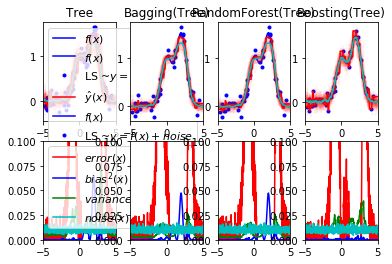

In [14]:
#this is for high bias models(like trees):
#using Bagging/RF can largely lower variance(~2x), and slightly lower bias
#using Boosting can largely lower bias(~10x), and slightly lower variance
param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':4}
estimators = [("Tree", DecisionTreeRegressor(**param)),
              ("Bagging(Tree)", BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(**param))),
             ("RandomForest(Tree)",RandomForestRegressor(n_estimators=100, **param)),
             ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, **param))]

compare_estimators(estimators)

Tree: -0.0254 (error) = 0.0003 (bias^2) + 0.0145 (var) + 0.0098 noise)
Bagging(Tree): -0.0139 (error) = 0.0004 (bias^2) + 0.0079 (var) + 0.0098 noise)
RandomForest(Tree): -0.0135 (error) = 0.0005 (bias^2) + 0.0079 (var) + 0.0098 noise)
Boosting(Tree): -0.0252 (error) = 0.0003 (bias^2) + 0.0145 (var) + 0.0098 noise)


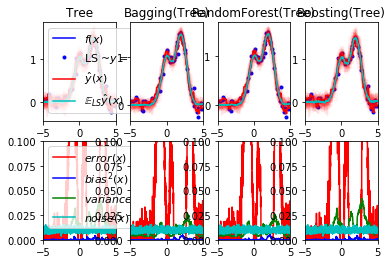

In [15]:
#this is for low bais models, such as deep/complex tree model:
#using bagging/RF can largely lower variance, but increase bias
#using boosting do not lower bias and variance
param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':10}
estimators = [("Tree", DecisionTreeRegressor(**param)),
              ("Bagging(Tree)", BaggingRegressor(n_estimators=200,base_estimator=DecisionTreeRegressor(**param))),
             ("RandomForest(Tree)",RandomForestRegressor(n_estimators=200, **param)),
             ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.03, n_estimators=500, **param))]

compare_estimators(estimators)